<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/hybrid_models_enconders_layering_w3_ST-HybridWaveStack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
▶️ Base path: /content/drive/MyDrive/ml_precipitation_prediction
Metrics_w3_ref2025-02


Loading ITables v2.4.0 from the internet... (need help?)


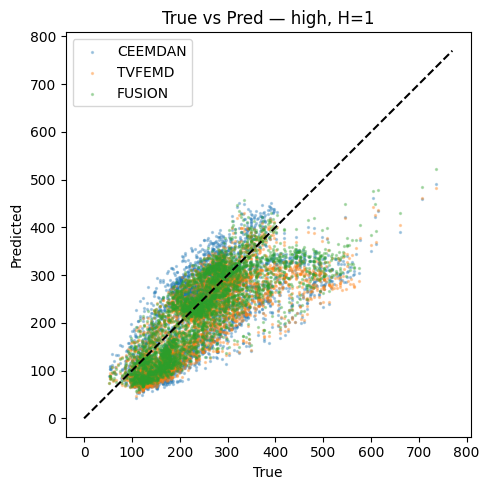

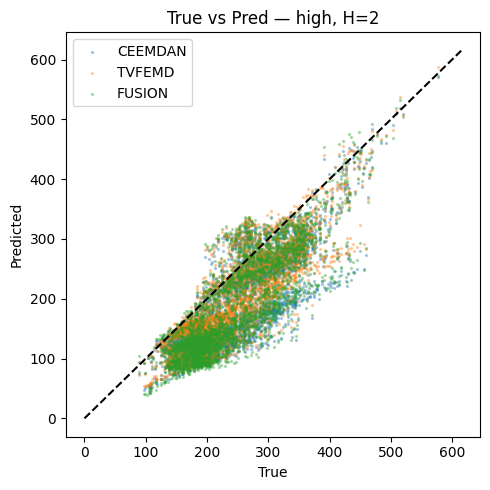

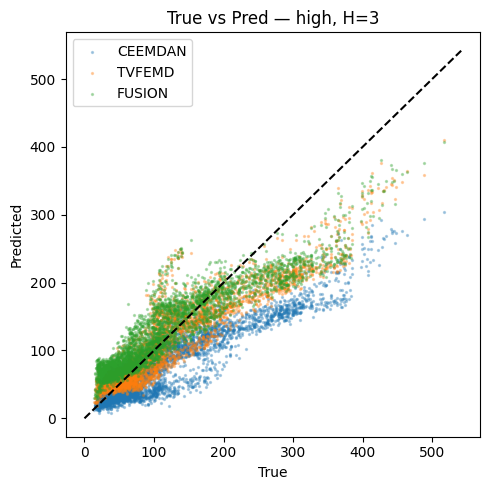

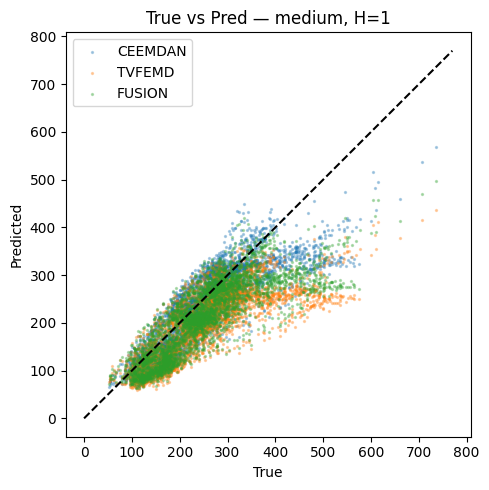

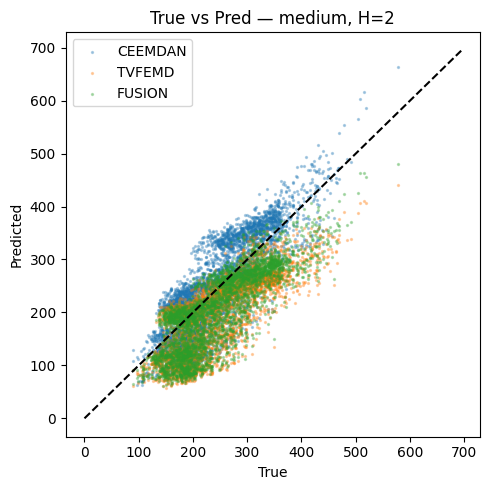

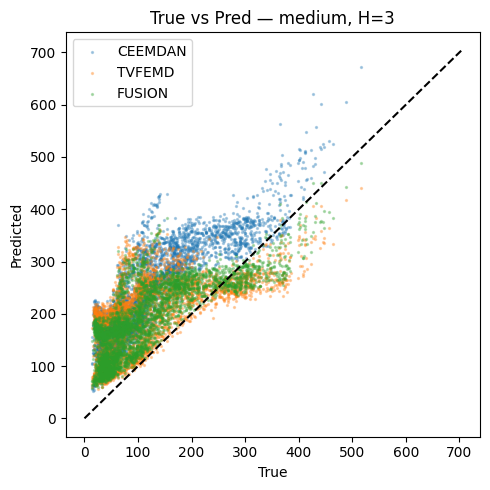

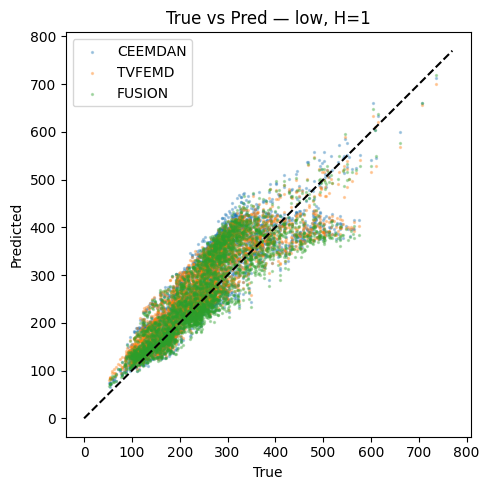

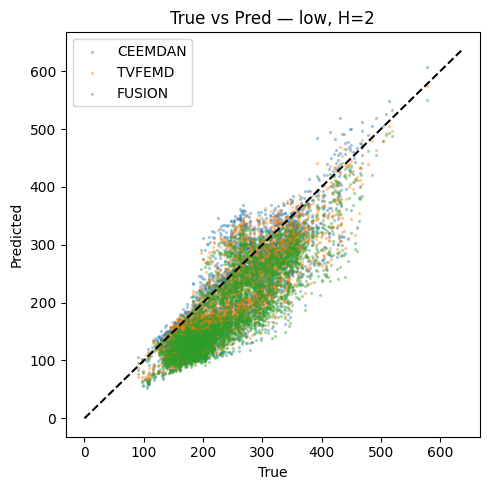

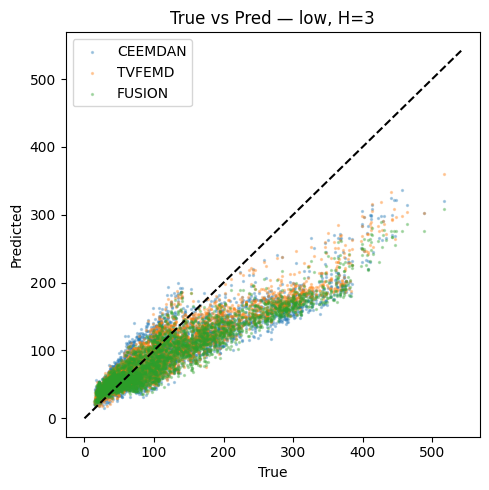

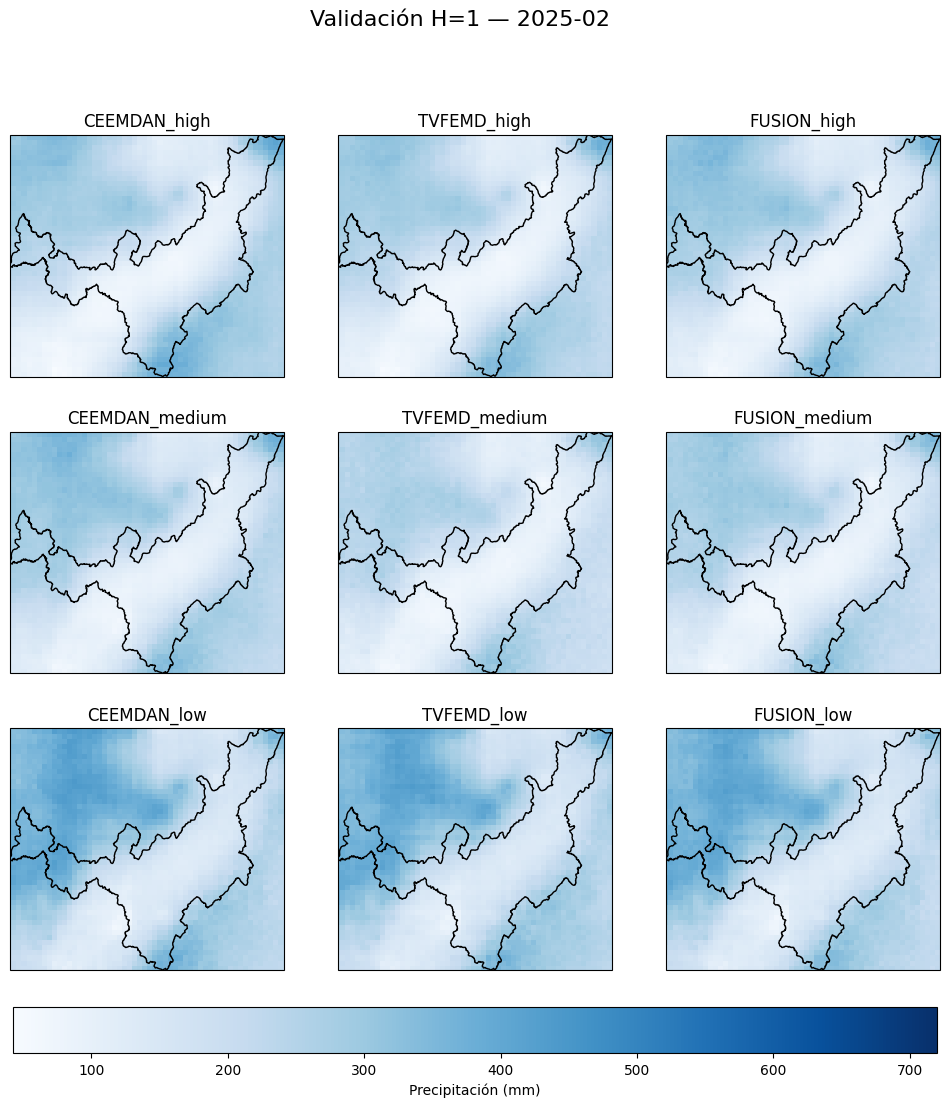

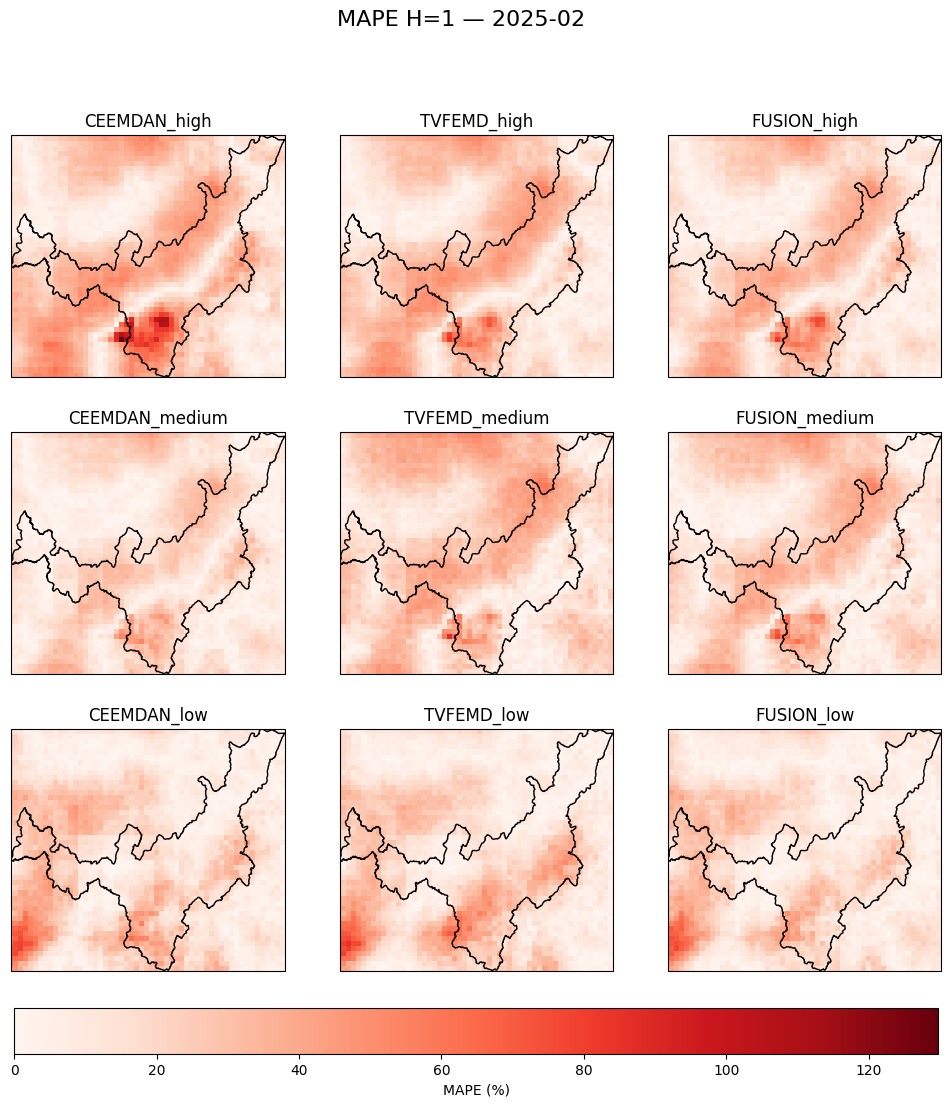

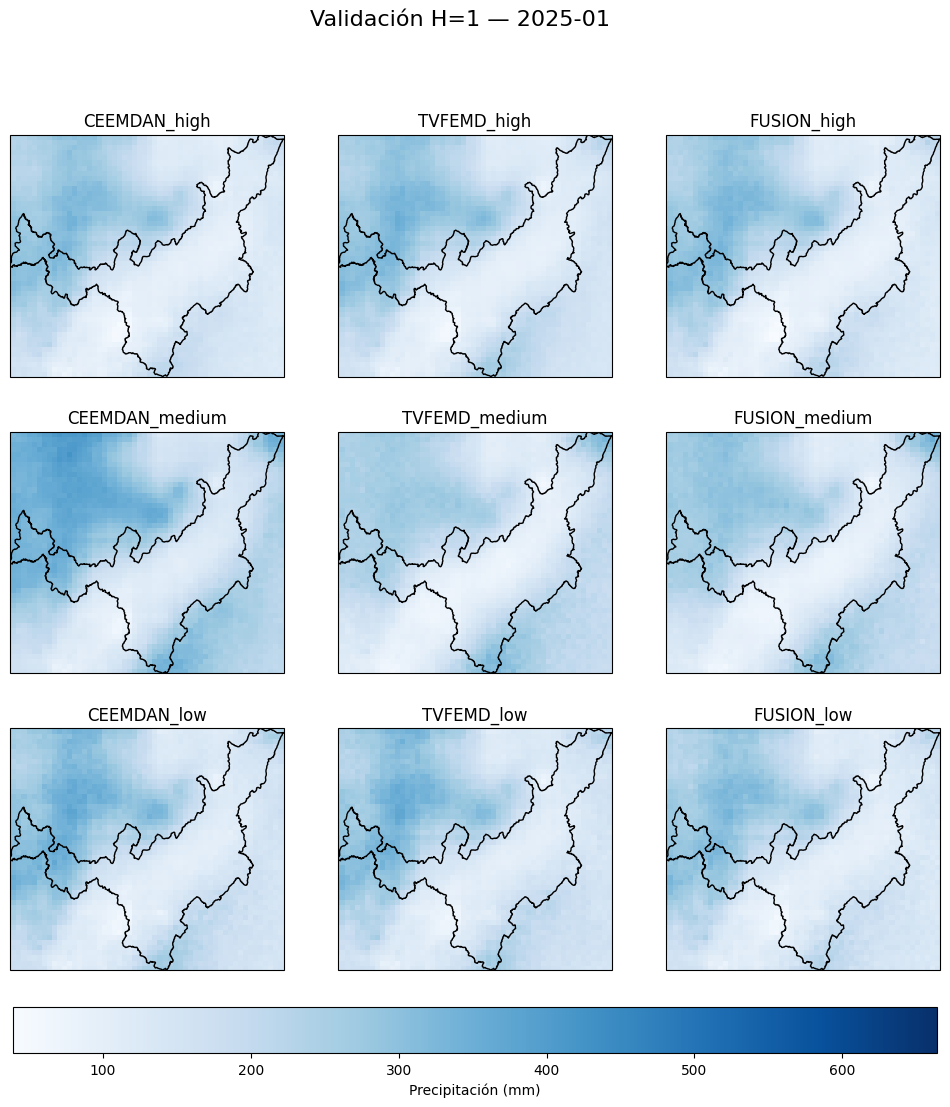

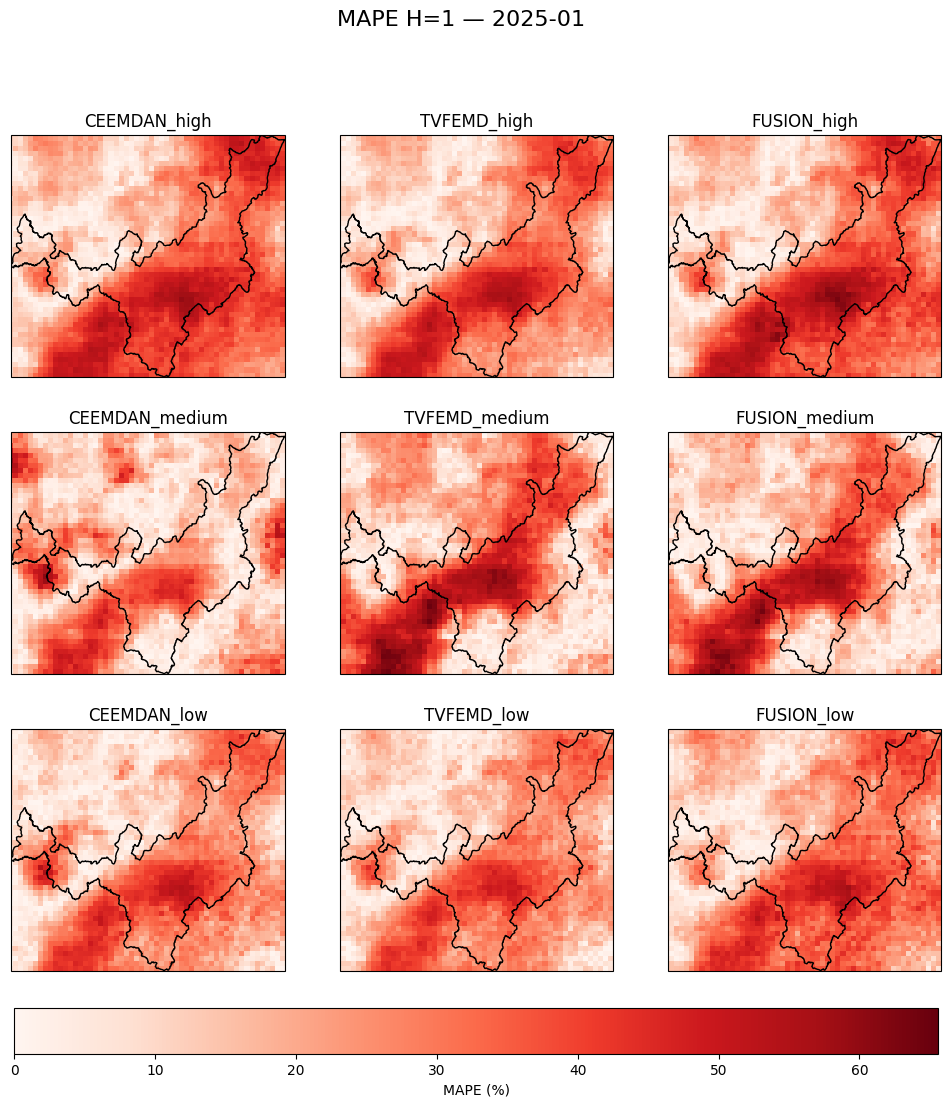

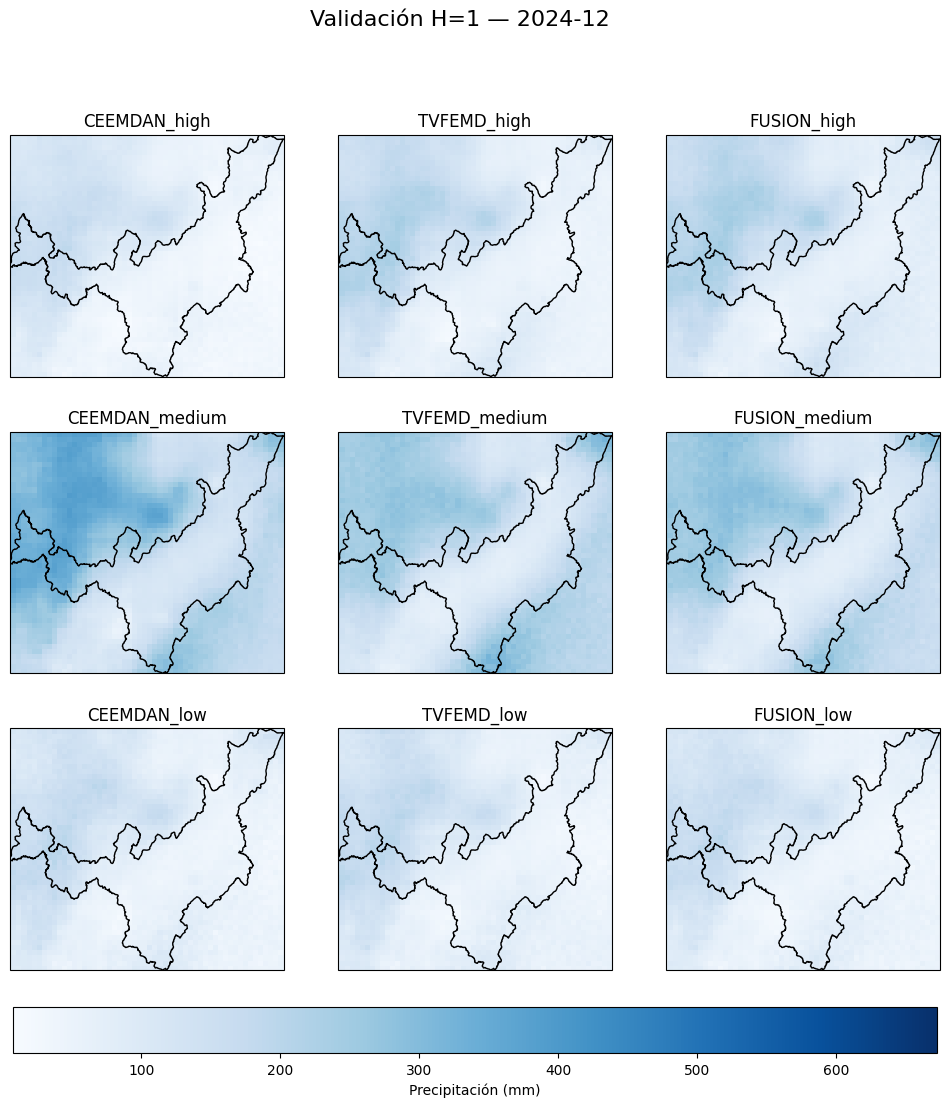

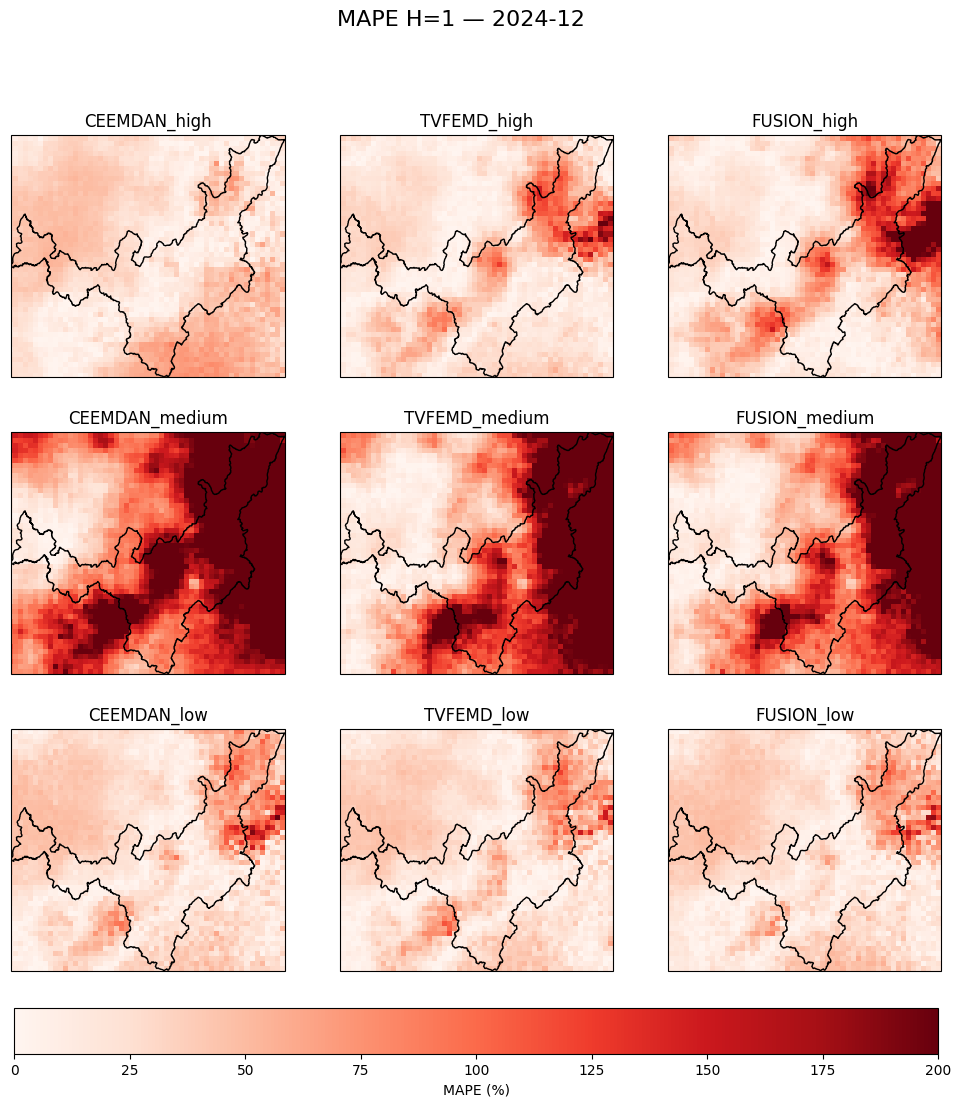

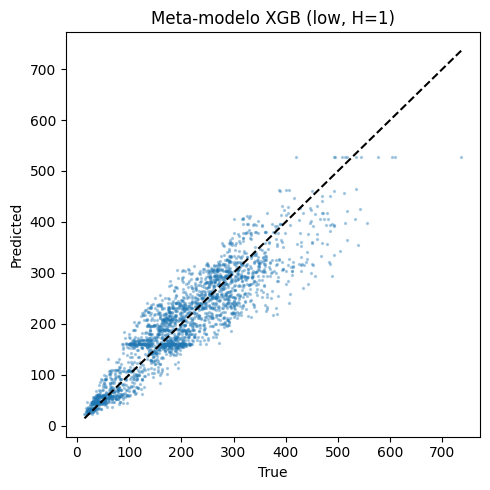

Modelo XGB exportado en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/trained_models/xgb_low_H1_2025-02.json
Meta-metrics H1-H3 ref2025-02


Loading ITables v2.4.0 from the internet... (need help?)


In [1]:
# -*- coding: utf-8 -*-
"""
Entrenamiento Multi‐rama con GRU encoder–decoder y Transformer para low,
validación y forecast parametrizables, meta‐modelo XGBoost (stacking low H=1),
paralelización, trazabilidad y límites del departamento de Boyacá.
"""

import sys
from pathlib import Path
import warnings
import logging

# 0) Detectar entorno (Local / Colab)
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    BASE_PATH = Path("/content/drive/MyDrive/ml_precipitation_prediction")
    !pip install -q xarray netCDF4 optuna seaborn cartopy xgboost ace_tools_open
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p/".git").exists():
            BASE_PATH = p
            break
print(f"▶️ Base path: {BASE_PATH}")

# 1) Suprimir warnings irrelevantes
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from cartopy.io import DownloadWarning
warnings.filterwarnings("ignore", category=DownloadWarning)
import tensorflow as tf
tf.get_logger().setLevel("ERROR")

# 2) Parámetros configurables
INPUT_WINDOW    = 60          # meses de entrada
OUTPUT_HORIZON  = 3           # meses de validación y forecast
REF_DATE        = "2025-03"   # fecha de referencia yyyy-mm
MAX_EPOCHS      = 300
PATIENCE_ES     = 30
LR_FACTOR       = 0.5
LR_PATIENCE     = 10
DROPOUT         = 0.1

# 3) Rutas y logger
MODEL_DIR    = BASE_PATH/"models"/"output"/"trained_models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FEATURES_NC  = BASE_PATH/"models"/"output"/"features_fusion_branches.nc"
FULL_NC      = BASE_PATH/"data"/"output"/"complete_dataset_with_features_with_clusters_elevation_with_windows.nc"
SHP_USER     = Path("/mnt/data/MGN_Departamento.shp")
BOYACA_SHP   = SHP_USER if SHP_USER.exists() else BASE_PATH/"data"/"input"/"shapes"/"MGN_Departamento.shp"
RESULTS_CSV  = MODEL_DIR/f"metrics_w{OUTPUT_HORIZON}_ref{REF_DATE}.csv"
IMAGE_DIR    = MODEL_DIR/"images"
IMAGE_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

# 4) Imports principales
import numpy            as np
import pandas           as pd
import xarray           as xr
import geopandas        as gpd
import matplotlib.pyplot as plt
import cartopy.crs      as ccrs
from sklearn.preprocessing import StandardScaler
import psutil
from joblib import cpu_count
from tensorflow.keras.layers import (
    Input, GRU, RepeatVector, TimeDistributed, Dense,
    MultiHeadAttention, Add, LayerNormalization, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks

# 5) Recursos hardware
CORES     = cpu_count()
AVAIL_RAM = psutil.virtual_memory().available / (1024**3)
gpus      = tf.config.list_physical_devices("GPU")
USE_GPU   = bool(gpus)
if USE_GPU:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    logger.info(f"🖥 GPU disponible: {gpus[0].name}")
else:
    tf.config.threading.set_inter_op_parallelism_threads(CORES)
    tf.config.threading.set_intra_op_parallelism_threads(CORES)
    logger.info(f"⚙ CPU cores: {CORES}, RAM libre: {AVAIL_RAM:.1f} GB")

# 6) Modelos y utilitarios
def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mae  = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/(y_true + 1e-5))) * 100
    r2   = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
    return rmse, mae, mape, r2

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=32, **kwargs):
        super().__init__(**kwargs)
        self.X, self.Y = X.astype(np.float32), Y.astype(np.float32)
        self.batch_size = batch_size
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    def __getitem__(self, idx):
        sl = slice(idx*self.batch_size, (idx+1)*self.batch_size)
        return self.X[sl], self.Y[sl]

def build_gru_ed(input_shape, horizon, n_cells, latent=128, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = GRU(latent, dropout=dropout)(inp)
    x = RepeatVector(horizon)(x)
    x = GRU(latent, dropout=dropout, return_sequences=True)(x)
    out = TimeDistributed(Dense(n_cells))(x)
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

def build_transformer_ed(input_shape, horizon, n_cells,
                         head_size=64, num_heads=4, ff_dim=256, dropout=0.1):
    inp = Input(shape=input_shape)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inp, inp)
    x = Add()([inp, attn])
    x = LayerNormalization(epsilon=1e-6)(x)
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dense(input_shape[-1])(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Flatten()(x)
    x = Dense(horizon * n_cells)(x)
    out = tf.reshape(x, (-1, horizon, n_cells))
    m = Model(inp, out)
    m.compile(optimizer="adam", loss="mse")
    return m

def build_gru_ed_low(input_shape, horizon, n_cells,
                     latent=256, dropout=0.1, use_transformer=True):
    if use_transformer:
        try:
            return build_transformer_ed(input_shape, horizon, n_cells,
                                        head_size=64, num_heads=4,
                                        ff_dim=512, dropout=dropout)
        except tf.errors.ResourceExhaustedError:
            logger.warning("OOM Transformer → usando GRU‐ED para low-branch")
    return build_gru_ed(input_shape, horizon, n_cells,
                        latent=latent, dropout=dropout)

def build_gru_ed_medium_high(input_shape, horizon, n_cells, latent=128, dropout=0.1, use_transformer=True):
    """
    Crea un modelo GRU Encoder-Decoder o Transformer Encoder-Decoder para medium y high.
    Si hay error de memoria con el Transformer, usa GRU-ED.
    """
    from tensorflow.keras.layers import (
        Input, GRU, RepeatVector, TimeDistributed, Dense,
        MultiHeadAttention, Add, LayerNormalization, Flatten
    )
    from tensorflow.keras.models import Model
    import tensorflow as tf

    def build_transformer_ed(input_shape, horizon, n_cells,
                             head_size=64, num_heads=4, ff_dim=256, dropout=0.1):
        inp = Input(shape=input_shape)
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inp, inp)
        x = Add()([inp, attn])
        x = LayerNormalization(epsilon=1e-6)(x)
        ff = Dense(ff_dim, activation="relu")(x)
        ff = Dense(input_shape[-1])(ff)
        x = Add()([x, ff])
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Flatten()(x)
        x = Dense(horizon * n_cells)(x)
        out = tf.reshape(x, (-1, horizon, n_cells))
        m = Model(inp, out)
        m.compile(optimizer="adam", loss="mse")
        return m

    def build_gru_ed(input_shape, horizon, n_cells, latent=128, dropout=0.1):
        inp = Input(shape=input_shape)
        x = GRU(latent, dropout=dropout)(inp)
        x = RepeatVector(horizon)(x)
        x = GRU(latent, dropout=dropout, return_sequences=True)(x)
        out = TimeDistributed(Dense(n_cells))(x)
        m = Model(inp, out)
        m.compile(optimizer="adam", loss="mse")
        return m

    try:
        if use_transformer:
            return build_transformer_ed(input_shape, horizon, n_cells,
                                        head_size=64, num_heads=4,
                                        ff_dim=512, dropout=dropout)
        else:
            return build_gru_ed(input_shape, horizon, n_cells,
                                latent=latent, dropout=dropout)
    except tf.errors.ResourceExhaustedError:
        print("⚠️ OOM Transformer → usando GRU‐ED para medium/high")
        return build_gru_ed(input_shape, horizon, n_cells,
                            latent=latent, dropout=dropout)

# 7) Carga datos y shapefile
logger.info("📂 Cargando datasets…")
ds_full = xr.open_dataset(FULL_NC)
ds_feat = xr.open_dataset(FEATURES_NC)
boyaca_gdf = gpd.read_file(BOYACA_SHP)
if boyaca_gdf.crs is None:
    boyaca_gdf.set_crs(epsg=4326, inplace=True)
else:
    boyaca_gdf = boyaca_gdf.to_crs(epsg=4326)

times      = ds_full.time.values.astype("datetime64[M]")
user_ref   = np.datetime64(REF_DATE, "M")
last_avail = times[-1]
if user_ref > last_avail:
    ref = last_avail
    logger.info(f"REF_DATE fuera de rango; usando último mes: {ref}")
else:
    ref = user_ref

# fechas explícitas
val_dates = [
    str(ref),
    str((ref - np.timedelta64(1,'M')).astype("datetime64[M]")),
    str((ref - np.timedelta64(2,'M')).astype("datetime64[M]"))
]
fc_dates  = [
    str((ref + np.timedelta64(i+1,'M')).astype("datetime64[M]"))
    for i in range(OUTPUT_HORIZON)
]

idx_ref = int(np.where(times == ref)[0][0])
lat     = ds_full.latitude.values
lon     = ds_full.longitude.values
METHODS   = ["CEEMDAN","TVFEMD","FUSION"]
BRANCHES  = ["high","medium","low"]

all_metrics = []
preds_store = {}
true_store  = {}
histories   = {}

# callbacks
es_cb = callbacks.EarlyStopping("val_loss", patience=PATIENCE_ES, restore_best_weights=True)
lr_cb = callbacks.ReduceLROnPlateau("val_loss", factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=1e-6)

# 8) Bucle principal
for method in METHODS:
    for branch in BRANCHES:
        name = f"{method}_{branch}"
        if name not in ds_feat.data_vars:
            logger.warning(f"⚠ {name} no existe, salto.")
            continue
        logger.info(f"▶ Procesando {name}")
        try:
            # extraer y aplanar
            Xarr = ds_feat[name].values            # (T, ny, nx)
            Yarr = ds_full["total_precipitation"].values  # (T, ny, nx)
            T, ny, nx = Xarr.shape
            n_cells   = ny * nx

            Xfull = Xarr.reshape(T, n_cells)
            yfull = Yarr.reshape(T, n_cells)

            # ventanas
            Nw = T - INPUT_WINDOW - OUTPUT_HORIZON + 1
            if Nw <= 0:
                logger.warning("❌ Ventanas insuficientes.")
                continue

            Xs = np.stack([Xfull[i : i+INPUT_WINDOW] for i in range(Nw)], axis=0)
            ys = np.stack([yfull[i+INPUT_WINDOW : i+INPUT_WINDOW+OUTPUT_HORIZON]
                           for i in range(Nw)], axis=0)

            # sin/cos para low
            if branch == "low":
                months = pd.to_datetime(ds_full.time.values).month.values
                s = np.sin(2 * np.pi * months/12)
                c = np.cos(2 * np.pi * months/12)
                Ss = np.stack([s[i : i+INPUT_WINDOW] for i in range(Nw)], axis=0)
                Cs = np.stack([c[i : i+INPUT_WINDOW] for i in range(Nw)], axis=0)
                Ss = np.repeat(Ss[:,:,None], n_cells, axis=2)
                Cs = np.repeat(Cs[:,:,None], n_cells, axis=2)
                Xs = np.concatenate([Xs, Ss, Cs], axis=2)
                n_feats = Xs.shape[2]
            else:
                n_feats = n_cells

            # escalado
            scX = StandardScaler().fit(Xs.reshape(-1, n_feats))
            scY = StandardScaler().fit(ys.reshape(-1, n_cells))
            Xs_s = scX.transform(Xs.reshape(-1, n_feats)).reshape(Xs.shape)
            ys_s = scY.transform(ys.reshape(-1, n_cells)).reshape(ys.shape)

            # partición centrada en REF_DATE
            k_ref = np.clip(idx_ref - INPUT_WINDOW + 1, 0, Nw-1)
            i0    = np.clip(k_ref - (OUTPUT_HORIZON-1), 0, Nw-OUTPUT_HORIZON)

            X_tr, y_tr = Xs_s[:i0], ys_s[:i0]
            X_va, y_va = Xs_s[i0 : i0+OUTPUT_HORIZON], ys_s[i0 : i0+OUTPUT_HORIZON]

            # cargar/entrenar
            model_path = MODEL_DIR/f"{name}_w{OUTPUT_HORIZON}_ref{ref}.keras"
            if model_path.exists():
                model = tf.keras.models.load_model(str(model_path), compile=False)
                model.compile(optimizer="adam", loss="mse")
                logger.info(f"⏩ Cargado modelo: {model_path.name}")
            else:
                if branch == "low":
                    model = build_gru_ed_low((INPUT_WINDOW, n_feats), OUTPUT_HORIZON, n_cells)
                else:
                    model = build_gru_ed_medium_high((INPUT_WINDOW, n_feats), OUTPUT_HORIZON, n_cells)

                hist = model.fit(
                    DataGenerator(X_tr, y_tr),
                    validation_data=DataGenerator(X_va, y_va),
                    epochs=MAX_EPOCHS,
                    callbacks=[es_cb, lr_cb],
                    verbose=1
                )
                model.save(str(model_path))
                histories[name] = hist.history

            # validación H=1..H
            preds = model.predict(X_va, verbose=0).reshape(OUTPUT_HORIZON, OUTPUT_HORIZON, n_cells)
            for h in range(OUTPUT_HORIZON):
                date_val = val_dates[h]
                pm_flat  = preds[h,0]
                tm_flat  = y_va[h,0]
                pm = scY.inverse_transform(pm_flat.reshape(1,-1))[0].reshape(ny,nx)
                tm = scY.inverse_transform(tm_flat.reshape(1,-1))[0].reshape(ny,nx)
                rmse, mae, mape, r2 = evaluate_metrics(tm.ravel(), pm.ravel())
                all_metrics.append({
                    "model": name, "branch": branch, "horizon": h+1,
                    "type":"validation", "date": date_val,
                    "RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2
                })
                preds_store[(name,date_val)] = pm
                true_store[(name,date_val)]  = tm

            # forecast
            X_fc = Xs_s[k_ref : k_ref+1]
            fc_s = model.predict(X_fc, verbose=0)[0]
            FC   = scY.inverse_transform(fc_s)
            for h in range(OUTPUT_HORIZON):
                date_fc = fc_dates[h]
                all_metrics.append({
                    "model": name, "branch": branch, "horizon": h+1,
                    "type":"forecast", "date": date_fc,
                    "RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan, "R2": np.nan
                })
                preds_store[(name,date_fc)] = FC[h].reshape(ny,nx)

        except Exception:
            logger.exception(f"‼ Error en {name}, continuo…")
            continue

# 9) Guardar métricas y mostrar tabla
dfm = pd.DataFrame(all_metrics)
dfm.to_csv(RESULTS_CSV, index=False)
import ace_tools_open as tools
tools.display_dataframe_to_user(name=f"Metrics_w{OUTPUT_HORIZON}_ref{ref}", dataframe=dfm)

# 10) Curvas de entrenamiento
for name, hist in histories.items():
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"],  label="train")
    plt.plot(hist["val_loss"],label="val")
    plt.title(f"Loss curve: {name}")
    plt.xlabel("Epoch"); plt.ylabel("MSE")
    plt.legend(); plt.tight_layout(); plt.show()

# 10bis) True vs Predicted por rama y horizonte
for branch in BRANCHES:
    for h in range(1, OUTPUT_HORIZON+1):
        plt.figure(figsize=(5,5))
        for method in METHODS:
            key = f"{method}_{branch}"
            date_val = val_dates[h-1]
            if (key, date_val) in preds_store and (key, date_val) in true_store:
                y_true = true_store[(key, date_val)].ravel()
                y_pred = preds_store[(key, date_val)].ravel()
                plt.scatter(y_true, y_pred, alpha=0.3, s=2, label=method)
        lims = [0, max(plt.xlim()[1], plt.ylim()[1])]
        plt.plot(lims, lims, 'k--')
        plt.xlabel("True"); plt.ylabel("Predicted")
        plt.title(f"True vs Pred — {branch}, H={h}")
        plt.legend(); plt.tight_layout(); plt.show()

# 11) Mapas 3×3 validación H=1
xmin, ymin, xmax, ymax = boyaca_gdf.total_bounds
for date_val in val_dates:
    arrs = [preds_store[(f"{m}_{b}",date_val)].ravel()
            for m in METHODS for b in BRANCHES
            if (f"{m}_{b}",date_val) in preds_store]
    if not arrs:
        logger.warning(f"No hay predicciones para {date_val}, salto plot.")
        continue
    vmin, vmax = np.min(arrs), np.max(arrs)
    fig, axs = plt.subplots(3,3, figsize=(12,12), subplot_kw={"projection":ccrs.PlateCarree()})
    fig.suptitle(f"Validación H=1 — {date_val}", fontsize=16)
    for i, b in enumerate(BRANCHES):
        for j, m in enumerate(METHODS):
            ax = axs[i,j]
            ax.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
            ax.add_geometries(boyaca_gdf.geometry, ccrs.PlateCarree(),
                              edgecolor="black", facecolor="none", linewidth=1)
            key = (f"{m}_{b}", date_val)
            if key in preds_store:
                pcm = ax.pcolormesh(lon, lat, preds_store[key],
                                    vmin=vmin, vmax=vmax,
                                    transform=ccrs.PlateCarree(), cmap="Blues")
            ax.set_title(f"{m}_{b}")
    fig.colorbar(pcm, ax=axs, orientation="horizontal",
                 fraction=0.05, pad=0.04, label="Precipitación (mm)")
    fig.savefig(IMAGE_DIR/f"val_H1_{date_val}.png", dpi=150); plt.show()

    arrs_mape = [
        np.clip(np.abs((true_store[k] - preds_store[k])/(true_store[k]+1e-5))*100,0,200).ravel()
        for k in preds_store if k[1]==date_val and k in true_store
    ]
    if not arrs_mape: continue
    vmin2, vmax2 = 0, np.max(arrs_mape)
    fig, axs = plt.subplots(3,3, figsize=(12,12), subplot_kw={"projection":ccrs.PlateCarree()})
    fig.suptitle(f"MAPE H=1 — {date_val}", fontsize=16)
    for i, b in enumerate(BRANCHES):
        for j, m in enumerate(METHODS):
            ax = axs[i,j]
            ax.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
            ax.add_geometries(boyaca_gdf.geometry, ccrs.PlateCarree(),
                              edgecolor="black", facecolor="none", linewidth=1)
            key = (f"{m}_{b}", date_val)
            if key in preds_store and key in true_store:
                mmap = np.clip(np.abs((true_store[key] - preds_store[key])/(true_store[key]+1e-5))*100,0,200)
                pcm2 = ax.pcolormesh(lon, lat, mmap,
                                     vmin=vmin2, vmax=vmax2,
                                     transform=ccrs.PlateCarree(), cmap="Reds")
            ax.set_title(f"{m}_{b}")
    fig.colorbar(pcm2, ax=axs, orientation="horizontal",
                 fraction=0.05, pad=0.04, label="MAPE (%)")
    fig.savefig(IMAGE_DIR/f"mape_H1_{date_val}.png", dpi=150); plt.show()

# 13) Meta‐modelo XGBoost (stacking low H=1)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_meta, y_meta = [], []
for date_val in val_dates:
    keys = [(f"{m}_low", date_val) for m in METHODS]
    if all(k in preds_store for k in keys) and keys[0] in true_store:
        arrs = [preds_store[k].ravel() for k in keys]
        X_meta.append(np.vstack(arrs).T)
        y_meta.append(true_store[keys[0]].ravel())

if X_meta:
    Xm = np.concatenate(X_meta, axis=0)
    ym = np.concatenate(y_meta, axis=0)
    Xtr, Xte, ytr, yte = train_test_split(Xm, ym, test_size=0.2, random_state=42)

    xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, n_jobs=-1, verbosity=0)
    xgb.fit(Xtr, ytr)

    # exportar modelo
    xgb.save_model(str(MODEL_DIR/f"xgb_low_H1_{ref}.json"))

    yhat = xgb.predict(Xte)
    rmse_meta = np.sqrt(mean_squared_error(yte, yhat))
    logger.info(f"Meta‐modelo XGB (low, H=1) RMSE: {rmse_meta:.3f}")

    plt.figure(figsize=(5,5))
    plt.scatter(yte, yhat, alpha=0.3, s=2)
    lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
    plt.plot(lims, lims, 'k--')
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.title("Meta‐modelo XGB (low, H=1)")
    plt.tight_layout(); plt.show()
    print(f"Modelo XGB exportado en: {MODEL_DIR/f'xgb_low_H1_{ref}.json'}")

    # 13bis) Tabla de métricas Meta‐modelo por mes
meta_metrics_all = []

for horizon in [1, 2, 3]:
    X_meta, y_meta = [], []
    for date_val in val_dates[:horizon]:
        keys = [(f"{m}_{b}", date_val) for m in METHODS for b in BRANCHES]
        if all(k in preds_store for k in keys) and keys[0] in true_store:
            arrs = [preds_store[k].ravel() for k in keys]
            X_meta.append(np.vstack(arrs).T)
            y_meta.append(true_store[keys[0]].ravel())  # siempre usamos low para verdad

    if not X_meta:
        logger.warning(f"⚠ No hay muestras para H={horizon}.")
        continue

    Xm = np.concatenate(X_meta, axis=0)
    ym = np.concatenate(y_meta, axis=0)

    Xtr, Xte, ytr, yte = train_test_split(Xm, ym, test_size=0.2, random_state=42)

    xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, n_jobs=-1, verbosity=0)
    xgb.fit(Xtr, ytr)

    model_path = MODEL_DIR / f"xgb_all_H{horizon}_{ref}.json"
    xgb.save_model(str(model_path))

    yhat = xgb.predict(Xte)
    rmse_meta = np.sqrt(mean_squared_error(yte, yhat))
    logger.info(f"Meta‐modelo XGB (all, H={horizon}) RMSE: {rmse_meta:.3f}")

    plt.figure(figsize=(5, 5))
    plt.scatter(yte, yhat, alpha=0.3, s=2)
    lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
    plt.plot(lims, lims, 'k--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Meta‐modelo XGB (all, H={horizon})")
    plt.tight_layout()
    plt.savefig(MODEL_DIR / f"xgb_all_H{horizon}_{ref}.png", dpi=150)
    plt.close()

    # Recalcular métricas a nivel global para ese horizonte
    rm, ma, maP, r_ = evaluate_metrics(ym, xgb.predict(Xm))
    meta_metrics_all.append({
        "horizon": f"1–{horizon}",
        "date": f"{val_dates[horizon-1]}",
        "H": horizon,
        "RMSE": rm,
        "MAE": ma,
        "MAPE": maP,
        "R2": r_
    })

# Exportar tabla completa
df_meta_all = pd.DataFrame(meta_metrics_all)
meta_csv_path = MODEL_DIR / f"meta_metrics_allH_ref{ref}.csv"
df_meta_all.to_csv(meta_csv_path, index=False)

import ace_tools_open as tools
tools.display_dataframe_to_user(name=f"Meta-metrics H1-H3 ref{ref}", dataframe=df_meta_all)
